In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from matplotlib import pyplot as plt
from data.dataloader import synthetic_dataset
from torch.utils.data import DataLoader
from model import Model

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


Bad key "text.kerning_factor" on line 4 in
c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def set_random_seed(seed):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic=True

set_random_seed(1)

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Epoch 1/500, Loss: 1.0962542295455933 - Val. loss: 1.0955417156219482
Stored a new best model at epoch 1.
Epoch 2/500, Loss: 1.083428978919983 - Val. loss: 1.016898512840271
Stored a new best model at epoch 2.
Epoch 3/500, Loss: 0.7674217224121094 - Val. loss: 1.3529566526412964
Epoch 4/500, Loss: 0.562959611415863 - Val. loss: 4.195335388183594
Epoch 5/500, Loss: 0.33506515622138977 - Val. loss: 5.846917152404785
Epoch 6/500, Loss: 0.24319279193878174 - Val. loss: 6.816821575164795
Epoch 7/500, Loss: 0.22118763625621796 - Val. loss: 7.795878887176514
Epoch 8/500, Loss: 0.20749232172966003 - Val. loss: 8.420478820800781
Epoch 9/500, Loss: 0.19969359040260315 - Val. loss: 7.911028861999512
Epoch 10/500, Loss: 0.191608726978302 - Val. loss: 7.898666858673096
Epoch 11/500, Loss: 0.18353019654750824 - Val. loss: 8.06145191192627
Epoch 12/500, Loss: 0.18405498564243317 - Val. loss: 7.219336986541748
Epoch 13/500, Loss: 0.17936669290065765 - Val. loss: 6.453970909118652
Epoch 14/500, Loss: 0

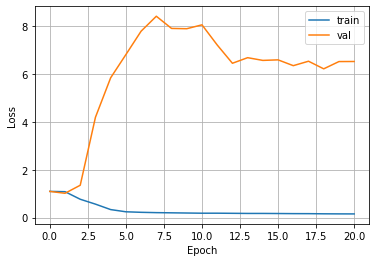

Epoch 22/500, Loss: 0.1502639800310135 - Val. loss: 5.97634220123291
Epoch 23/500, Loss: 0.14538376033306122 - Val. loss: 6.054964065551758
Epoch 24/500, Loss: 0.14160434901714325 - Val. loss: 6.093959808349609
Epoch 25/500, Loss: 0.13875727355480194 - Val. loss: 5.676858425140381
Epoch 26/500, Loss: 0.13599750399589539 - Val. loss: 6.065313816070557
Epoch 27/500, Loss: 0.13206154108047485 - Val. loss: 5.857879161834717
Epoch 28/500, Loss: 0.13220404088497162 - Val. loss: 5.761203289031982
Epoch 29/500, Loss: 0.13001133501529694 - Val. loss: 5.3386688232421875
Epoch 30/500, Loss: 0.12583844363689423 - Val. loss: 5.1229963302612305
Epoch 31/500, Loss: 0.12560270726680756 - Val. loss: 4.91797399520874
Epoch 32/500, Loss: 0.12619377672672272 - Val. loss: 4.82455587387085
Epoch 33/500, Loss: 0.12025570869445801 - Val. loss: 4.405755043029785
Epoch 34/500, Loss: 0.12290375679731369 - Val. loss: 4.496983528137207
Epoch 35/500, Loss: 0.11748247593641281 - Val. loss: 4.356833457946777
Epoch 36

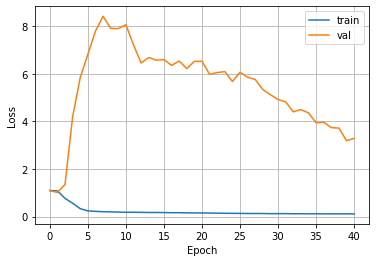

Epoch 42/500, Loss: 0.11200282722711563 - Val. loss: 3.1514978408813477
Epoch 43/500, Loss: 0.11600083112716675 - Val. loss: 3.183000087738037


KeyboardInterrupt: 

In [3]:
device = 'cuda:0'

# Some settings related to the synthetic data
nr_classes = 3
nr_channels = 2
window_length = 3000
k = 1 # The number of mini-windows to select per window
nr_epochs = 500

settings = {
'hypernet_settings':{'input_dim':[nr_channels,window_length],  
                    'output_channels':[8,16,32,64], 
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3],  #The last layer has no pooling, so no pooling factor needs to be set.
                    'gumbel_softmax_temperature':{'start':10.0, 'end':0.1, 'nr_epochs':nr_epochs//2}, # nr_epochs is the nr of iterations in which the temperature decays from start to end
                    'k': k, 
                    }, 
'encoder_settings':{
                    'output_channels':[8,16,32,64],
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3]}, #The last layer is a adaptive average pooling, so no pooling factor needs to be set.
'sampling_type':'learned',
'nr_classes':nr_classes
}

# Define the model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.to(device)

# Define optimizer and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, verbose=True, min_lr=1e-6) #, last_epoch=nr_epochs//2-1)  #init the last_epoch at the point where we start using the scheduler.

# Create dataloaders for the train and validation sets
data_loaders = []
for data_fold in ['train', 'val']:
    data_set = synthetic_dataset(data_fold=data_fold, channels=['ch0','ch1'], nr_classes=nr_classes)
    data_loaders.append(DataLoader(data_set,
                                    batch_size=128,
                                    shuffle= True if data_fold == 'train' else False,
                                    drop_last=False,
                                    pin_memory=True,
                                    num_workers= 0))
data_loader_train, data_loader_val = data_loaders

# Training loop
num_epochs = 500
all_losses = {'train':[], 'val':[]}
best_val_loss = np.inf

for epoch in range(num_epochs):
    total_loss_train = []
    model.train()
    for x_train, y_train in data_loader_train:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Zero the gradients
        model.zero_grad()

        # Forward pass
        y_hat_train = model(x_train, epoch)
        loss =  F.nll_loss(y_hat_train, y_train)
        total_loss_train.append(loss.clone().to('cpu').detach().numpy())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_loss_val = []
    with torch.no_grad():
        for x_val, y_val in data_loader_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_hat_val = model(x_val, epoch)
            loss_val =  F.nll_loss(y_hat_val, y_val)
            total_loss_val.append(loss_val.clone().to('cpu').detach().numpy())
    
    if epoch > (nr_epochs//2-1):     
        scheduler.step(metrics=loss_val) 

    all_losses['train'].append(np.mean(total_loss_train))
    all_losses['val'].append(np.mean(total_loss_val))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {all_losses['train'][-1]} - Val. loss: {all_losses['val'][-1]}")

    if all_losses['val'][-1] < best_val_loss:
        best_val_loss = all_losses['val'][-1]
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'Stored a new best model at epoch {epoch+1}.' )

    if (epoch > 0 and epoch % 20 == 0) or (epoch == nr_epochs-1):    
        # The validation loss first increases, while the train loss decreases due to 
        # the fact that during training soft samples are used, which are annealed to hard samples during training via the GS temperature parameter.
        plt.plot(all_losses['train'], label='train')
        plt.plot(all_losses['val'], label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    if epoch == 400:  #TODO remove
        break

In [ ]:
from sklearn.metrics import f1_score

# Load the best model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

# Evaluate the model on the test dataset
data_set = synthetic_dataset(data_fold='test', channels=['ch0','ch1'], nr_classes=nr_classes)
data_loader_test = DataLoader(data_set,
                    batch_size=128,
                    shuffle= False,
                    drop_last=False,
                    pin_memory=True,
                    num_workers= 0)


total_loss_test = []
all_y_test, all_y_hat_test = [], []
with torch.no_grad():
    for x_test, y_test in data_loader_val:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        y_hat_test = model(x_test, epoch)
        loss_test = F.nll_loss(y_hat_test, y_test)
        total_loss_test.append(loss_test.clone().to('cpu').detach().numpy())

        all_y_test.extend(y_test.clone().to('cpu').detach().numpy())
        all_y_hat_test.extend(y_hat_test.clone().to('cpu').detach().numpy())

print(f"Test loss: {np.mean(total_loss_test)}")
# The class-average F1 score as provided in the paper in Table 1.
print(f1_score(all_y_test, np.stack(all_y_hat_test,0).argmax(1), average='macro', labels=[0,1,2]))


Test loss: 0.11284070461988449
0.9473373348191888
